In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
from skimage import measure
import argparse
import imutils
from PIL import Image
import seaborn as sns

# Import Data Set

In [3]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

In [4]:
train_csv.head(5)

img_id              input_img              label_img
0   10000  train_input_10000.png  train_label_10000.png
1   10001  train_input_10001.png  train_label_10001.png
2   10002  train_input_10002.png  train_label_10002.png
3   10003  train_input_10003.png  train_label_10003.png
4   10004  train_input_10004.png  train_label_10004.png

In [5]:
train_csv.shape
test_csv.shape

(20, 3)

In [6]:
train_all_input = 'train_input_img/'+train_csv['input_img']
train_all_label = 'train_label_img/'+train_csv['label_img']
test_input_files = 'test_input_img/'+test_csv['input_img']

In [7]:
print('length of train input and label files:',len(train_all_input), len(train_all_label))

length of train input and label files: 622 622


In [8]:
len(test_input_files)

20

In [8]:
# to visualize first five images subset the train datasets
train_input_files = train_all_input[1:6].to_numpy()
train_label_files = train_all_label[1:6].to_numpy()

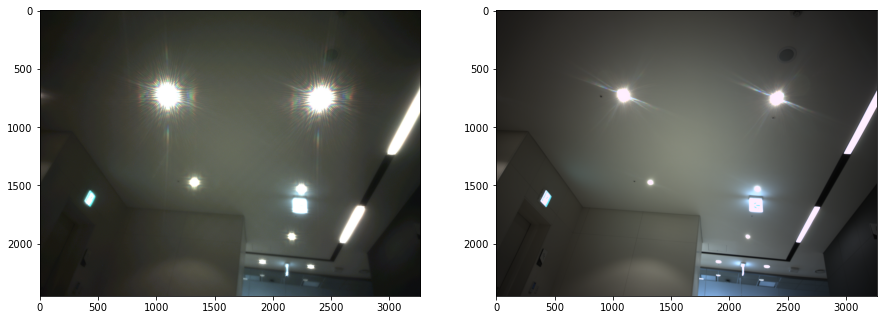

train_input_img/train_input_10001.png train_label_img/train_label_10001.png 



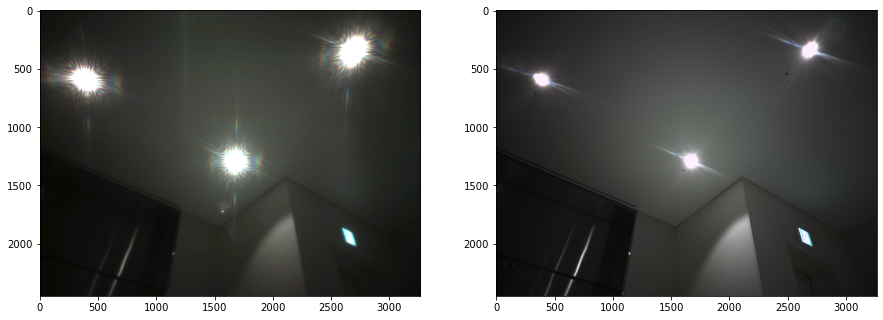

train_input_img/train_input_10002.png train_label_img/train_label_10002.png 



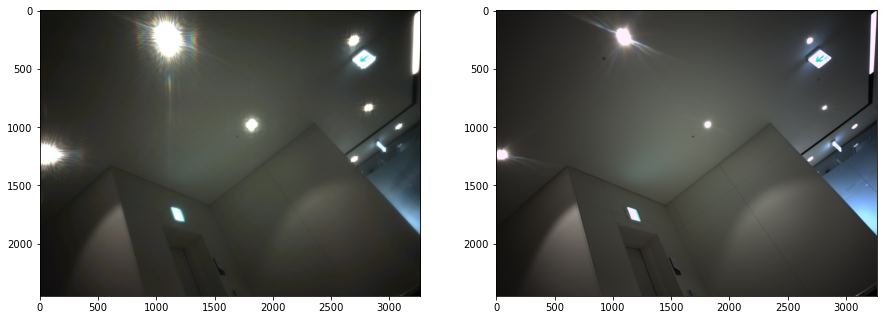

train_input_img/train_input_10003.png train_label_img/train_label_10003.png 



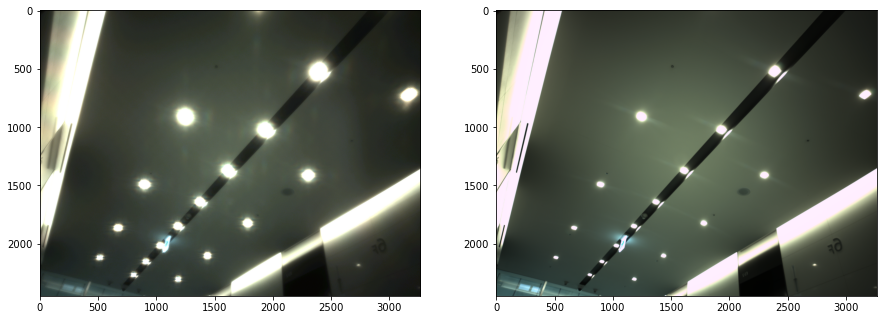

train_input_img/train_input_10004.png train_label_img/train_label_10004.png 



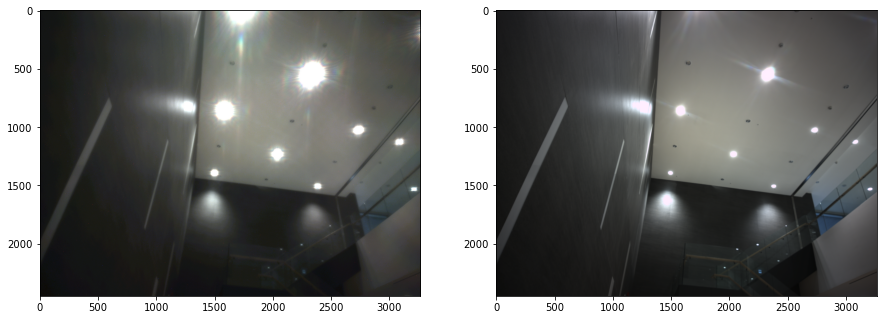

train_input_img/train_input_10005.png train_label_img/train_label_10005.png 



In [10]:
for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(15,10))
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(inp_img)
    plt.subplot(1,2,2)
    plt.imshow(targ_img)
    plt.show()
    print(input_path, label_path, '\n')

In [9]:
# subset 90% of train dataset as train set
train_input_files = train_all_input[62:].to_numpy()
train_label_files = train_all_label[62:].to_numpy()
# subset 10% of train dataset as validation set
val_input_files = train_all_input[:62].to_numpy()
val_label_files = train_all_label[:62].to_numpy()

## PCA 

In [12]:
for i in train_input_files[0:5]:
    image = cv2.imread(i, cv2.IMREAD_COLOR)
    print(image.shape) #height, width, channels 

(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)


The shape of image was (2448, 3264, 3)

In [39]:
# to find the elbow for the pca_explained variance ratio
from sklearn.decomposition import PCA
def PCA_image(data, n):
    #res = []
    pca_b_res = []
    pca_g_res = []
    pca_r_res = []
    #for i in train_input_files[0:m]:
    for i in range(0, len(data)):
        img = cv2.cvtColor(cv2.imread(data[i]), cv2.COLOR_BGR2RGB)
        blue,green,red = cv2.split(img)
        df_blue = blue /225
        df_green = green/225
        df_red = red/225
        pca_b = PCA(n_components = n)
        pca_b.fit(df_blue)
        trans_pca_b = pca_b.transform(df_blue)
        pca_g = PCA(n_components = n)
        pca_g.fit(df_green)
        trans_pca_g = pca_g.transform(df_green)
        pca_r = PCA(n_components = n)
        pca_r.fit(df_red)
        #trans_pca_r = pca_r.transform(df_red)
        #res.append([sum(pca_b.explained_variance_ratio_), sum(pca_g.explained_variance_ratio_), sum(pca_r.explained_variance_ratio_)])
        pca_b_res.append(sum(pca_b.explained_variance_ratio_))
        pca_g_res.append(sum(pca_g.explained_variance_ratio_))
        pca_r_res.append(sum(pca_r.explained_variance_ratio_))
    return pca_b_res, pca_g_res, pca_r_res
    #return (sum(pca_b.explained_variance_ratio_)), sum(pca_g.explained_variance_ratio_), sum(pca_r.explained_variance_ratio_)

In [10]:
channel_res = PCA_image(train_input_files[0:4], n = 5)

In [11]:
b_channel = []
g_channel = []
r_channel = []
n_component = np.arange(0, 31, 5)
n_component[0] = 1
n_component
for i in n_component:
    b_channel.append(np.mean(PCA_image(train_input_files[0:4], n = i)[0]))
    g_channel.append(np.mean(PCA_image(train_input_files[0:4], n = i)[1]))
    r_channel.append(np.mean(PCA_image(train_input_files[0:4], n = i)[2]))

In [12]:
channels = pd.DataFrame({'components': n_component,
                        'b_channel': b_channel,
                        'g_channel': g_channel,
                        'r_channel': r_channel,})

Text(0.5, 1.0, 'Red Channel')

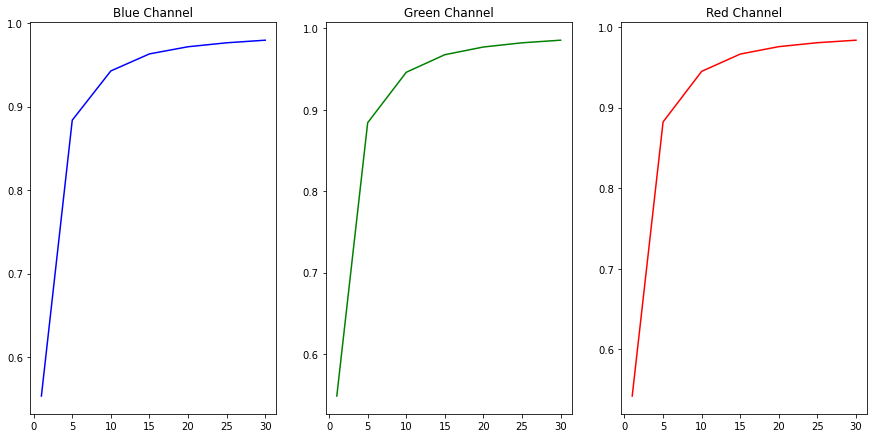

In [13]:
#fig = plt.figure(figsize = (15, 7.2)) 
xs = [n_component for i in n_component]
fig = plt.figure(figsize = (15, 7.2)) 
ax1 = plt.subplot(131)
ax1.set_title('Blue Channel')
ax1.plot(channels['components'],channels['b_channel'], c= 'blue')
ax2 = plt.subplot(132)
ax2.plot(channels['components'],channels['g_channel'], c='green')
ax2.set_title('Green Channel')
ax3 = plt.subplot(133)
ax3.plot(channels['components'],channels['r_channel'], c= 'red')
ax3.set_title('Red Channel')


In [14]:
channels

components  b_channel  g_channel  r_channel
0           1   0.553384   0.548400   0.541987
1           5   0.883660   0.884033   0.882212
2          10   0.942631   0.946017   0.944984
3          15   0.963010   0.967612   0.966449
4          20   0.971569   0.977055   0.975665
5          25   0.976298   0.982203   0.980561
6          30   0.979416   0.985409   0.983664

## PCA with n = 20 components to the whole datasets

In [10]:
from sklearn.decomposition import PCA
def PCA_all(data, n): # n is number of components
    img_reduced_res = []
    for i in range(0, len(data)):
        # to greyscale
        img = cv2.cvtColor(cv2.imread(data[i]), cv2.COLOR_BGR2RGB)
        # scale to 0 to 255
        blue,green,red = cv2.split(img)
        df_blue = blue / 255
        df_green = green / 255
        df_red = red / 255
        pca_b = PCA(n_components = n)
        pca_b.fit(df_blue)
        trans_pca_b = pca_b.transform(df_blue)
        pca_g = PCA(n_components = n)
        pca_g.fit(df_green)
        trans_pca_g = pca_g.transform(df_green)
        pca_r = PCA(n_components = n)
        pca_r.fit(df_red)
        trans_pca_r = pca_r.transform(df_red)
        # merge PCA dimensionality reduction
        b_arr = pca_b.inverse_transform(trans_pca_b)
        g_arr = pca_g.inverse_transform(trans_pca_g)
        r_arr = pca_r.inverse_transform(trans_pca_r)
        img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
        img_reduced_res.append(img_reduced)
    return img_reduced_res

In [41]:
# contain all the reduced img figures! 
reduced_img_res_all = PCA_all(train_input_files, n = 20)

In [11]:
# for submissions
reduced_img_results = PCA_all(train_input_files[0:4], n=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


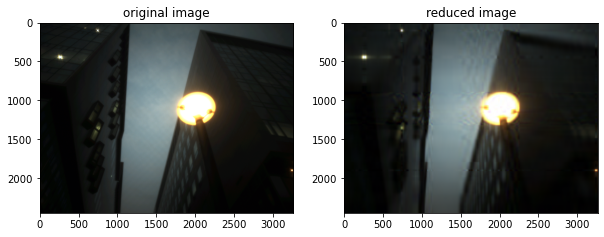

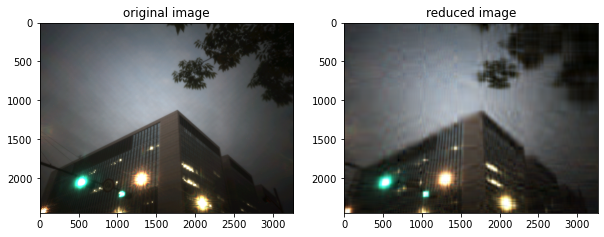

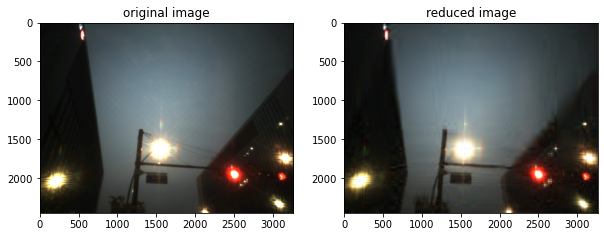

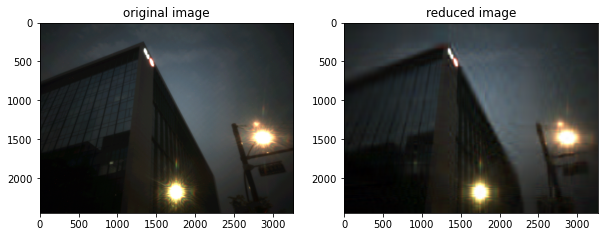

In [17]:
# plots
for i in range(0, len(reduced_img_results)):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 7.2))
    fig.add_subplot(121)
    plt.title('original image')
    plt.imshow(inp_img)
    fig.add_subplot(122)
    plt.title('reduced image')
    plt.imshow(reduced_img_results[i])
    plt.show

## Autoencoder 

In [194]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [195]:
def gray_to_all(data):
    grey_all_list = []
    for i in range(0, len(data)):
        img = cv2.imread(data[i])
        grey_all_list.append(rgb2gray(img))
    return grey_all_list

In [197]:
#gray_train_ex = gray_to_all(train_input_files)
#gray_test_ex = gray_to_all(test_input_files)

In [198]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import backend as K
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras

In [199]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (256, 256, 1))
    return img

In [200]:
train_set = []
test_set = []
for i in train_input_files:
    train_set.append(process_image(i))
for i in test_input_files:
    test_set.append(process_image(i))

In [201]:
train_cleaned = []
for i in train_label_files:
    train_cleaned.append(process_image(i))

In [202]:
X_train = np.asarray(train_set)
X_test = np.asarray(test_set)
Y_train = np.asarray(train_cleaned)

In [203]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [206]:
from keras import datasets, layers, models, losses, Model

In [252]:
def autoencoder_():
    input_layer = Input(shape=(256, 256, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoder
    encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
    encoder = BatchNormalization()(encoder)

    # decoder
    decoder= Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
    decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder= BatchNormalization()(decoder)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model2 = autoencoder_()
model2.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 256, 256, 128)     73856     
_________________________________________________________________
batch_normalization_16 (Batc (None, 256, 256, 128)     512       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 256, 256, 128)     147584    
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 256, 256, 64)      73792     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256, 256, 64)    

In [253]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model2.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=20, batch_size=24, verbose=1, callbacks=[callback])

Epoch 1/20
20/20 [==============================] - 271s 14s/step - loss: 0.0570 - mae: 0.1652 - val_loss: 0.0889 - val_mae: 0.2782
Epoch 2/20
20/20 [==============================] - 314s 16s/step - loss: 0.0236 - mae: 0.0992 - val_loss: 0.0316 - val_mae: 0.1548
Epoch 3/20
20/20 [==============================] - 331s 17s/step - loss: 0.0143 - mae: 0.0781 - val_loss: 0.0290 - val_mae: 0.1452
Epoch 4/20
20/20 [==============================] - 327s 16s/step - loss: 0.0141 - mae: 0.0748 - val_loss: 0.0217 - val_mae: 0.1191
Epoch 5/20
20/20 [==============================] - 326s 16s/step - loss: 0.0129 - mae: 0.0699 - val_loss: 0.0227 - val_mae: 0.1068
Epoch 6/20
20/20 [==============================] - 320s 16s/step - loss: 0.0120 - mae: 0.0708 - val_loss: 0.0177 - val_mae: 0.0970
Epoch 7/20
20/20 [==============================] - 302s 15s/step - loss: 0.0093 - mae: 0.0598 - val_loss: 0.0164 - val_mae: 0.0979
Epoch 8/20
20/20 [==============================] - 325s 16s/step - loss: 0.

In [254]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

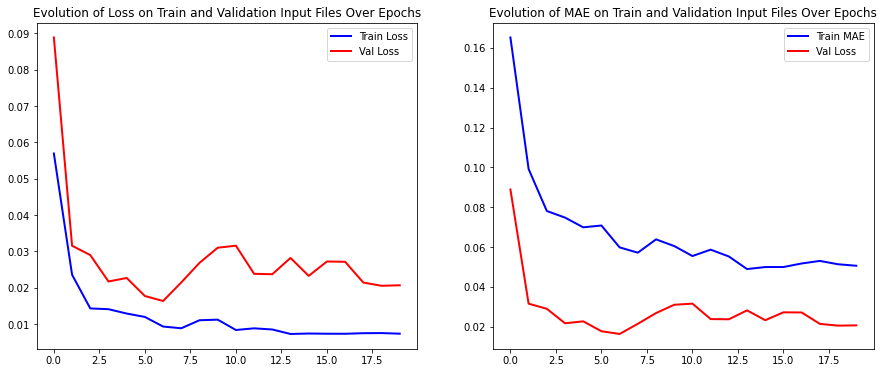

In [260]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of Loss on Train and Validation Input Files Over Epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of MAE on Train and Validation Input Files Over Epochs')
plt.legend(loc='best')
plt.show()

In [263]:
Y_test = model2.predict(X_test, batch_size = 16)

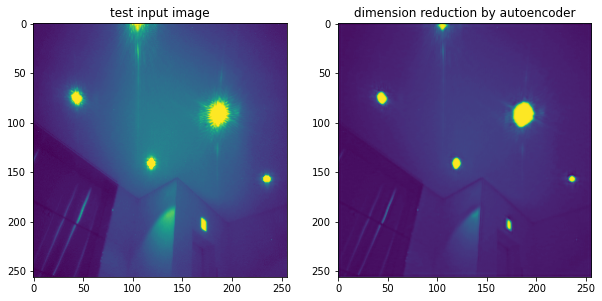

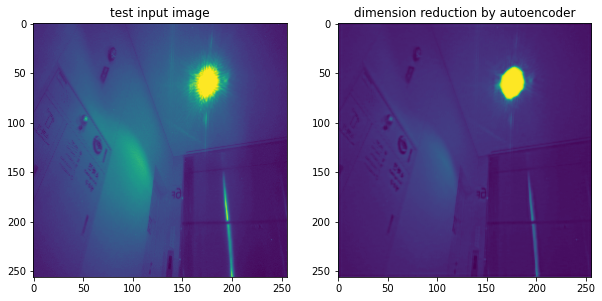

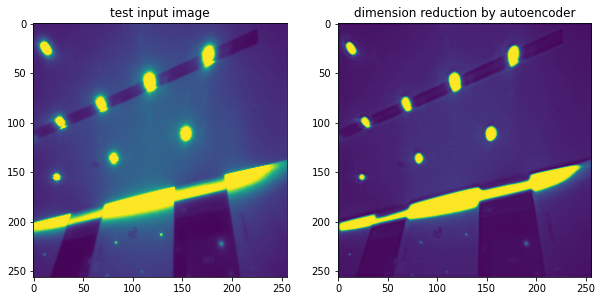

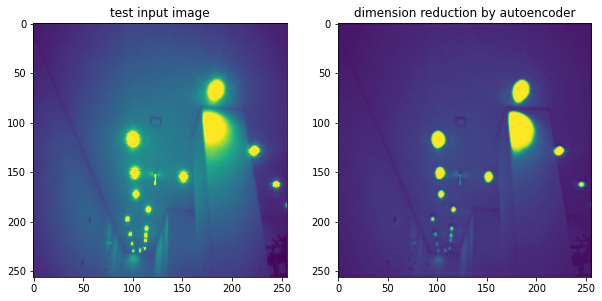

In [264]:
# plots
for i in range(0, 4):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 5.2))
    fig.add_subplot(121)
    plt.title('test input image')
    plt.imshow(X_test[i])
    fig.add_subplot(122)
    plt.title('dimension reduction by autoencoder')
    plt.imshow(Y_test[i])
    plt.show

## K-means clustering

using resource https://www.kaggle.com/code/pmmilewski/pca-decomposition-and-keras-neural-network/notebook

In [18]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 6)

def elbow_method(X):
    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)

        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / X.shape[0])
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1)) / X.shape[0]
        mapping2[k] = kmeanModel.inertia_
    return mapping1, mapping2

In [19]:
def k_means_elbow(data):
    k_means_elbow1 = []
    k_means_elbow2 = []
    for i in range(0, len(data)):
        img = data[i]
        vectorize = img.reshape(-1,3)
        #vectorize = i.reshape((-1,3))
        vectorize = np.float32(vectorize)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        elbow_result1, elbow_result2 = elbow_method(vectorize)
        k_means_elbow1.append(elbow_result1)
        k_means_elbow2.append(elbow_result2)
    return k_means_elbow1, k_means_elbow2
    

In [100]:
k_means_elbow_res1, k_means_elbow_res2 = k_means_elbow(reduced_img_results)

In [104]:
k_means_elbow_res1[1][1]
k_means_elbow_plot = []
for i in range(0, len(k_means_elbow_res1)):
    a = np.mean(k_means_elbow_res1[i][1])
    b = np.mean(k_means_elbow_res1[i][2])
    c = np.mean(k_means_elbow_res1[i][3])
    d = np.mean(k_means_elbow_res1[i][4])
    e = np.mean(k_means_elbow_res1[i][5])

### applied to one image with 1 - 10 clusters

In [240]:
#img = cv2.cvtColor(cv2.imread(train_input_files[1]), cv2.COLOR_BGR2RGB)
img = img_reduced.copy() * 225
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

cv.TERM_CRITERIA_EPS stop the algorithm tieration if specific accuracy, epsilon is reached
????ELBO METHOD

In [271]:
elbow_result1, elbow_result2 = elbow_method(vectorized)

In [272]:
elbow_result1

{1: 70.52835619729238,
 2: 40.60402278664009,
 3: 27.062808552601705,
 4: 21.98507193464142,
 5: 18.166393589264654,
 6: 17.197514822695933,
 7: 15.312993410416318,
 8: 13.634130920711248,
 9: 12.61365939842307,
 10: 12.379787959203457}

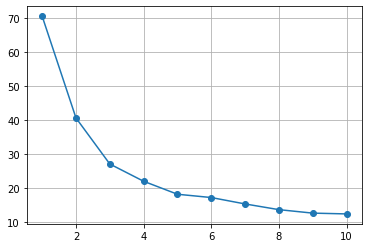

In [278]:
num_k = list(elbow_result1.keys())
result_k = list(elbow_result1.values())
plt.plot(num_k, result_k, '-o')
plt.grid(True)

In [279]:
K = 4 # based on the elbow method k =4 clusters are selected
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [280]:
center = np.uint8(center)

In [281]:
res = center[label.flatten()]
result_image = res.reshape((img_reduced.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


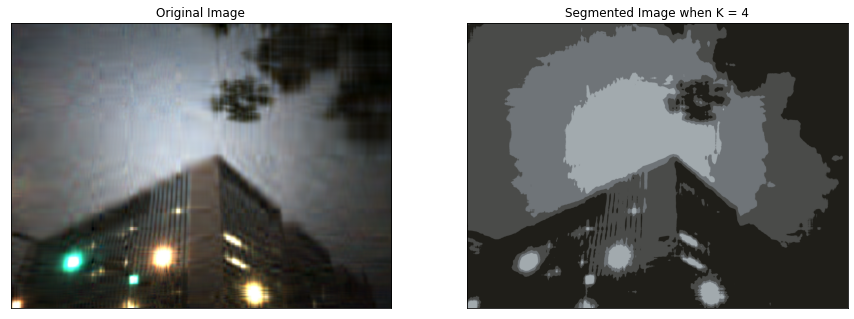

In [282]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img_reduced)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()


### K-means with n =4 with multiple images

In [138]:
def K_means_(X):
    for i in X:
        #img = cv2.imread(i)
        img = i * 225
        vectorized = img.reshape((-1,3))
        vectorized = np.float32(vectorized)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        
        K = 4 # based on the elbow method k =4 clusters are selected
        attempts=10
        ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        result_image = res.reshape((img.shape))
        figure_size = 15
        plt.figure(figsize=(figure_size,figure_size))
        plt.subplot(1,2,1),plt.imshow(i.astype('uint8'))
        plt.title('PCA with 20 components'), plt.xticks([]), plt.yticks([])
        plt.subplot(1,2,2),plt.imshow(result_image)
        plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
        plt.show()
        #print(i, '\n')
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


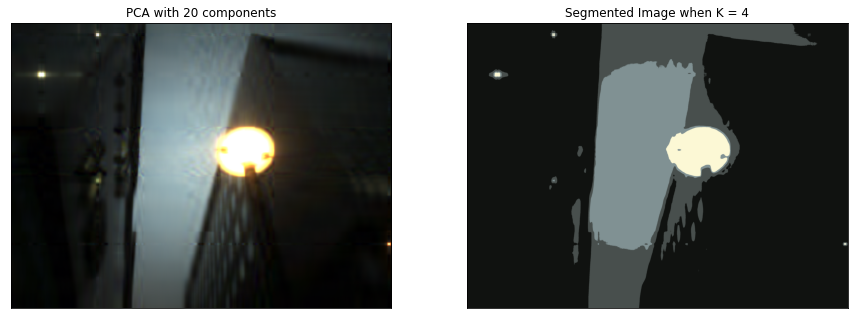

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


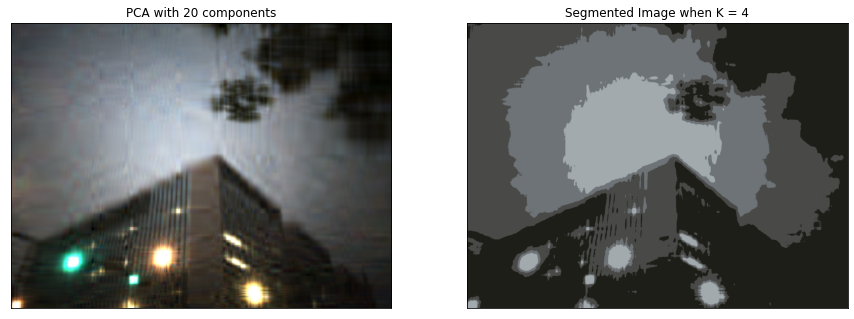

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


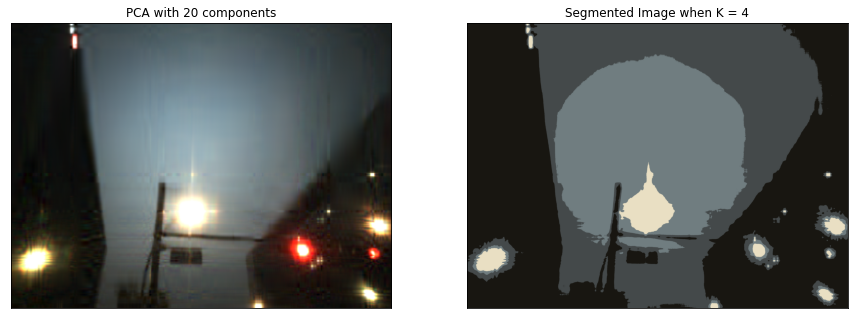

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


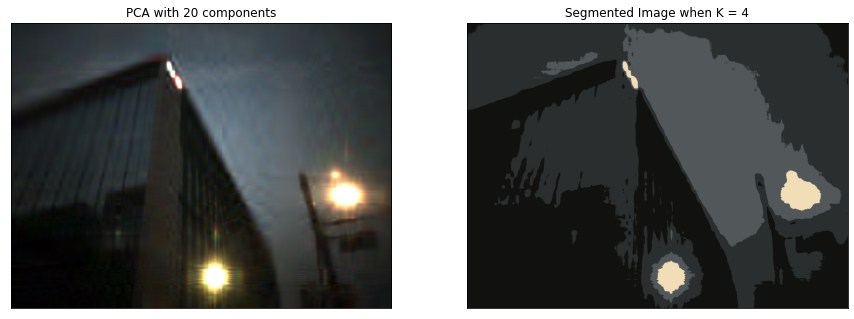

In [137]:
K_means_(reduced_img_results)

### Image segmentation using GMM

#### Applied to one image

In [111]:
from sklearn.mixture import GaussianMixture
from skimage import io
from sklearn.metrics import silhouette_score

In [147]:
def SelBest(arr:list, X:int)->list:
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [343]:
# rgb_weights = [0.2989, 0.5870, 0.1140]
# grayscale_image = np.dot(img_reduced[...,:3], rgb_weights)
# grayscale_image.shape
# #img = grayscale_image.copy()

In [39]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
img_reduced = reduced_img_results[1]
gray = rgb2gray(img_reduced)

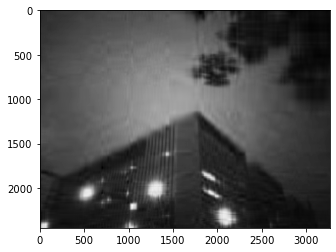

In [42]:
plt.imshow(gray, cmap = plt.get_cmap('gray'))

using rgb does not work well so the reduced image converted into grayscale and used GMM

In [87]:
#img = img_reduced.copy() * 225
img = reduced_img_results[1]*255
vectorized = img.reshape((-1,3))
img = vectorized.copy()

In [56]:
def predict_transform(frame, is_gray):
    color_dim = 3 if not is_gray else 1
    return frame.reshape((-1, color_dim))

def predict_untransform(frame, dims):
    return frame.reshape((dims[0], dims[1]))

In [241]:
# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,9)

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=2, init_params='kmeans')
    # Fit the model 
    labels = model.fit_predict(gray)
    # Calculate Silhoutte Score and append to a list
    S.append(silhouette_score(gray, labels, metric='euclidean'))

In [243]:
S

[0.319770272417869,
 0.29344149702717587,
 0.30978298651148817,
 0.3738353094363055,
 0.4013859449069428,
 0.3996236571610696,
 0.4391500811185801]

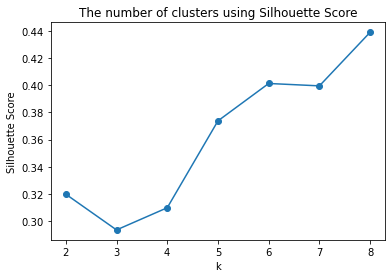

In [247]:
plt.plot(range(2,9), S, 'o-')
plt.title("BIC Scores", fontsize=20)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The number of clusters using Silhouette Score')
plt.show()

In [188]:
def gmm_image_segmentation(img, n):
    origianl_size = img[0].shape
    for i in img:
        gmm = GaussianMixture(n_components=n, covariance_type="tied").fit(predict_transform(i, True))
        pred = gmm.predict(predict_transform(i, True))
        cluster = pred.reshape(2448, 3264)
        figure_size = 15
        plt.figure(figsize=(figure_size,figure_size))
        plt.subplot(1,2,1),plt.imshow(i)
        plt.title('PCA with 20 components'), plt.xticks([]), plt.yticks([])
        plt.subplot(1,2,2),plt.imshow(cluster)
        plt.title('GMM Image Segmentation'), plt.xticks([]), plt.yticks([])
        plt.show()
        

In [190]:
def convert_to_gray(data):
    res = []
    for i in data:
        #img = cv2.imread(i)
        res.append(rgb2gray(i))
    return res

In [191]:
conv_to_gray_ex = convert_to_gray(reduced_img_results)

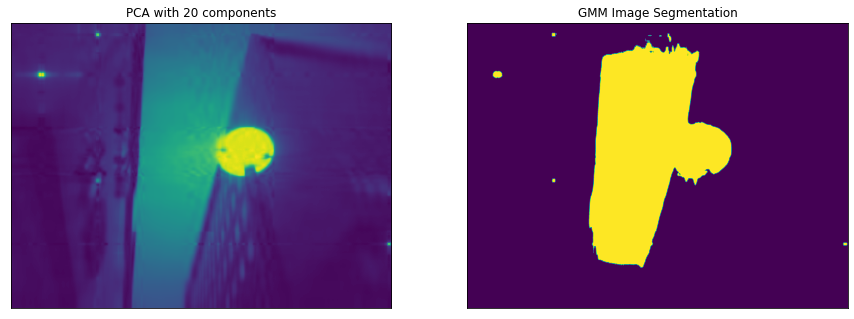

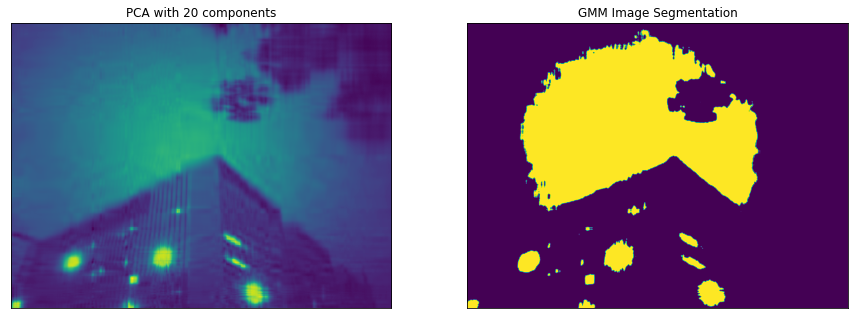

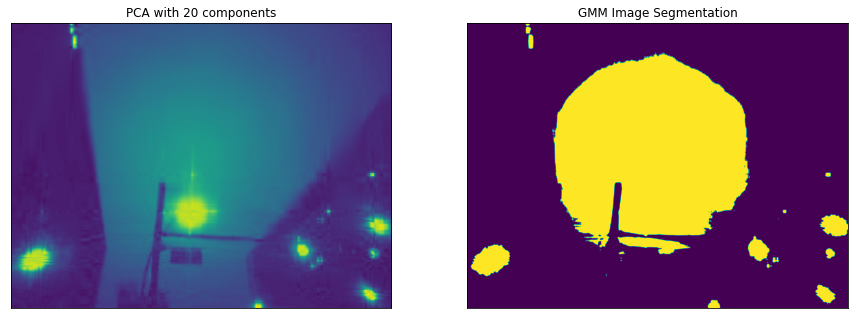

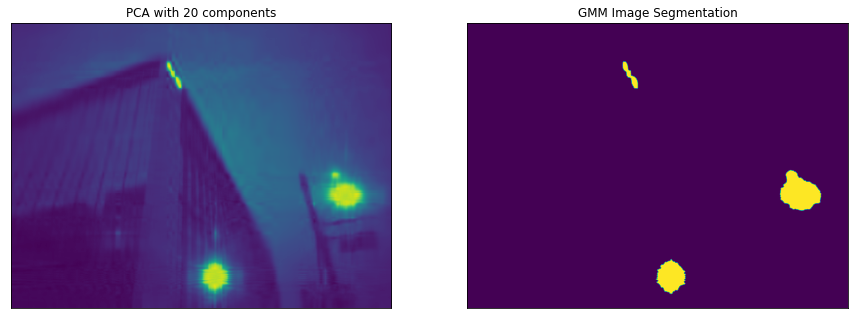

In [251]:
gmm_image_segmentation(conv_to_gray_ex, 2)

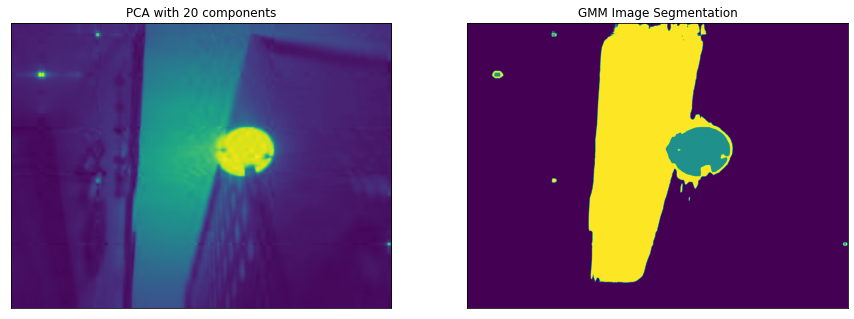

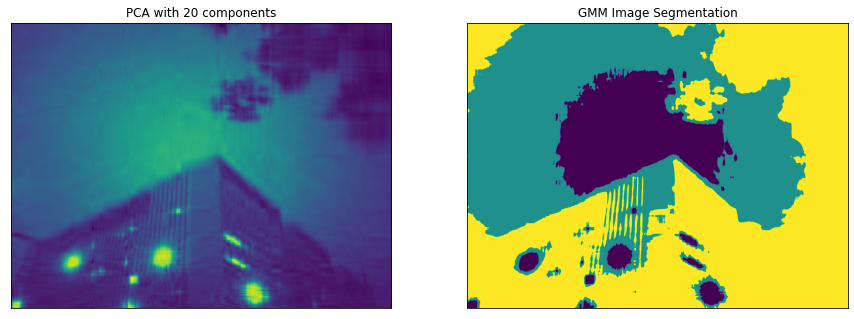

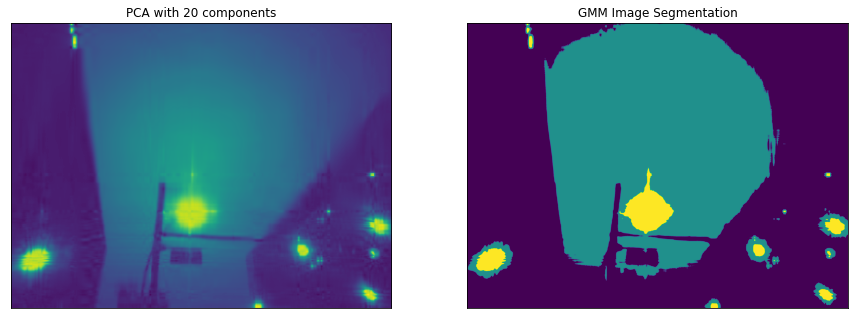

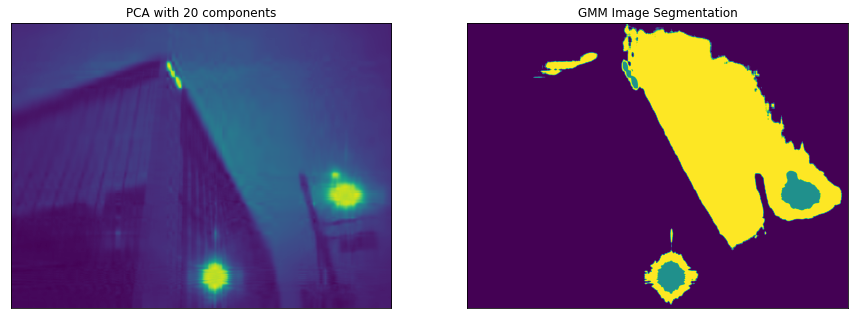

In [249]:
gmm_image_segmentation(conv_to_gray_ex, 3)

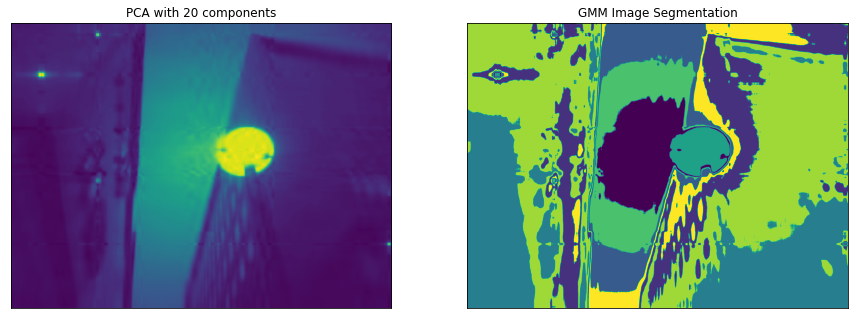

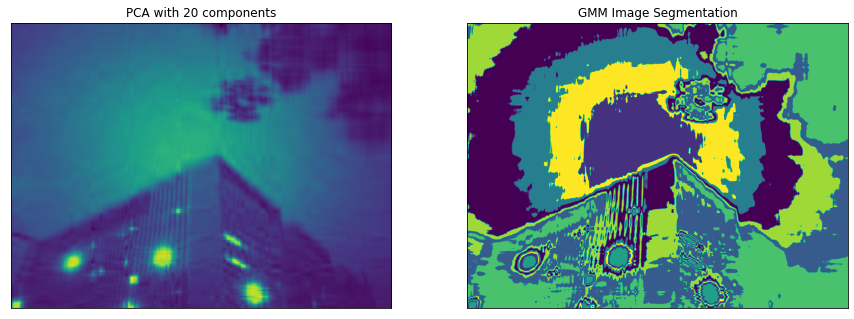

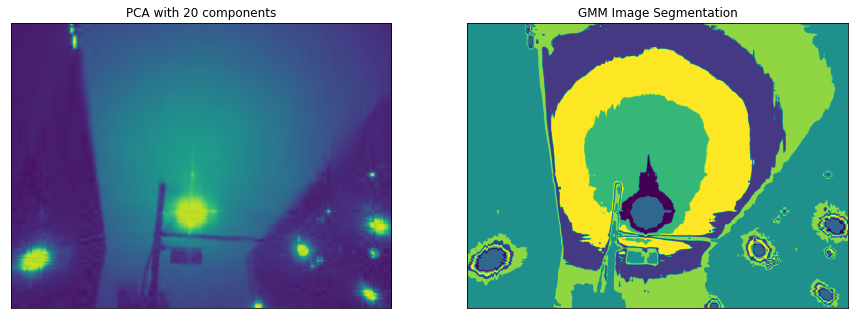

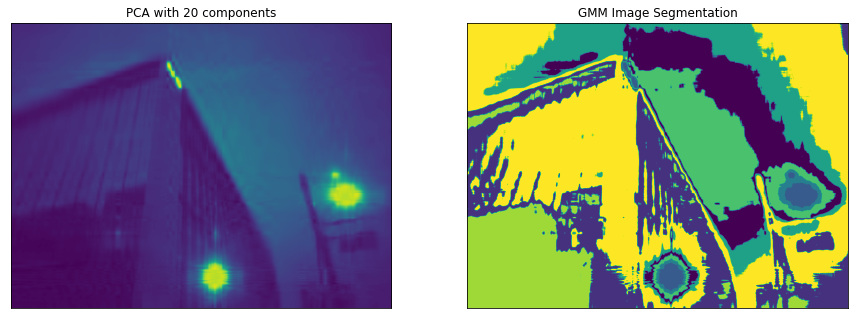

In [248]:
gmm_image_segmentation(conv_to_gray_ex, 8)

In [155]:
def BIC_GMM(data):
    n_clusters=np.arange(2, 8)
    bics=[]
    bics_err=[]
    iterations=20
    original_size = data.shape
    tmp_bic=[]
    for n in n_clusters:
        #for _ in range(iterations):
            #gmm=GaussianMixture(n, n_init=2).fit(X_principal) 
        gmm = GaussianMixture(n_components=n,covariance_type="tied")
        gmm = gmm.fit(data)
        tmp_bic.append(gmm.bic(data))
        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)
    return bics, bics_err

In [156]:
bics, bics_error = BIC_GMM(gray)

Text(0, 0.5, 'Score')

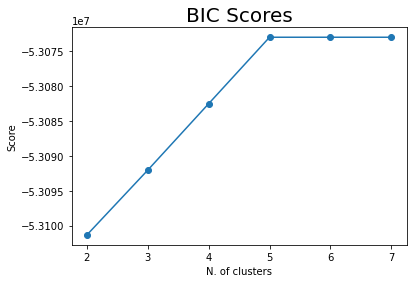

In [166]:
plt.plot(np.arange(2, 8),bics, '-o')
plt.title("BIC Scores", fontsize=20)
plt.xticks(np.arange(2, 8))
plt.xlabel("N. of clusters")
plt.ylabel("Score")

## Histogram and KDE 

useful resources: https://towardsdatascience.com/introduction-to-image-processing-with-python-histogram-manipulation-for-beginners-8b107d4c4fef

In [20]:
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage import img_as_ubyte, img_as_float
from skimage.exposure import histogram, cumulative_distribution

In [98]:
# find optimal bandwidth for histogram
def optimal_hist(data):
    sig = np.std(data)
    N = len(data)
    h_hat = 3.5 * sig * (N**(-1/3))
    return h_hat

In [99]:
# save all the optimal bandwidth for dataset
def optimal_hist_all(data):
    #data = data * 255
    optimal_hist_res = []
    for i in range(0, len(data)):
        optimal_hist_res.append(optimal_hist(data[i]))
    return optimal_hist_res

In [ ]:
optimal_hist_res_all = optimal_hist_all(reduced_img_res_all)

In [100]:
optimal_hist_res_ex = optimal_hist_all(reduced_img_results)
optimal_hist_res_ex

[0.054724758506560466,
 0.05002232206246219,
 0.05165074782568741,
 0.037095301425046315]

In [101]:
# find optimal bandwith for gaussian kernel 
def optimal_kernel(data):
    sig = np.std(data)/np.sqrt(len(data))
    n = len(data) ** (-1/5)
    res = 1.06 * sig * n
    return res

In [102]:
def optimal_kernel_all(data):
    optimal_kernel_res = []
    for i in range(0, len(data)):
        optimal_kernel_res.append(optimal_kernel(data[i]))
    return optimal_kernel_res

In [ ]:
optimal_kernel_res_all = optimal_kernel_all(reduced_img_res_all)

In [103]:
optimal_kernel_res_ex = optimal_kernel_all(reduced_img_results)

In [105]:
optimal_kernel_res_ex

[0.0009481072984072029,
 0.0008666375133480124,
 0.0008948500152057056,
 0.0006426766782988228]

In [110]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth = optimal_kernel_res_ex[0], kernel='gaussian')
kde.fit(reduced_img_results[0].reshape(-1,3))
logprob = kde.scores_samples()


KernelDensity(bandwidth=0.0009481072984072029)

In [111]:
def histogram_adjuster_color(image):
    freq, bins = cumulative_distribution(image)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    interpolation = np.interp(freq, target_freq, target_bins)
    image_eq = img_as_ubyte(interpolation[image].astype(int))
    freq_adj, bins_adj = cumulative_distribution(image_eq)
    
    
    fig, axes = plt.subplots(1, 2, figsize=(15,7));
    imshow(image, ax = axes[0]);
    imshow(image_eq, ax = axes[1]);
    
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].set_title('Unadjusted Image', fontsize = 17)
    axes[1].set_title('Adjusted Image', fontsize = 17)
    
    fig, axes = plt.subplots(1, 1, figsize=(19,7));
    plt.step(bins, freq, c='blue', label='Actual CDF')
    plt.step(bins_adj, freq_adj, c='purple', label='Adjusted CDF')
    plt.plot(target_bins, 
             target_freq, 
             c='red', 
             label='Target CDF',
             linestyle = '--')
    
    plt.legend(prop={'size': 15})
    plt.xlim(0, 255)
    plt.ylim(0, 1)
    plt.xlabel('Intensity values', fontsize = 17)
    plt.ylabel('Cumulative fraction of pixels', fontsize = 17);

In [ ]:
histogram_adjuster_color(np.array(test* 255, 'uint8'))

In [104]:
dark_image_grey = reduced_img_results[1]
freq, bins = cumulative_distribution(dark_image_grey)

In [115]:
test.shape

(2448, 3264, 3)

https://www.kaggle.com/code/risviana/digital-image-processing-histogram-processing/notebook
smoothing cv2.blur https://pyimagesearch.com/2021/04/28/opencv-smoothing-and-blurring/